

# AI REGIO Jupyter Notebook for Quality control on production lines with Computer Vision and TinyML

**Quality control on production lines** with computer vision and TinyML involves using computer vision algorithms and TinyML technology to automatically inspect and detect defects in products as they move along the production line.

**Computer Vision (CV) algorithms** can be used to analyze images of products and compare them to a "good" or "reference" image to identify any defects. These algorithms can be trained to detect a wide range of defects, including scratches, dents, misalignments, and missing components. Additionally, Computer Vision algorithms are able to work in real-time, allowing it to detect defects in products as they move along the production line and flag them for further inspection or rejection.

**TinyML** is a field that involves developing machine learning models that can run on small, resource-constrained devices such as microcontrollers. In the context of quality control on production lines, TinyML can be used to enable the **CV algorithms to run on embedded devices**, such as cameras or sensors, that are integrated into the production line. This allows the system to process images and make decisions about defects without the need to send data to a separate computer for analysis.

By combining computer vision algorithms and TinyML technology, it's possible to create a **real-time, automated quality control system** that can detect defects in products as they are produced, improving the overall quality and efficiency of the production process.

It's important to notice that, this system typically require a lot of data and a proper machine learning pipeline to be able to be able to improve and adapt over time.

**This Notebook assumes that there is available a dataset of labeled images of a product and demonstrates:**
- Dataset overview
- Data preparation and augmentation
- CV model creation for image classification
- Model transformation to TinyML using TfLite
- Comparison between the original and TfLite model


**Sources**
- Image Classification: https://www.tensorflow.org/tutorials/images/classification
- Data preparation and augmentation: https://www.tensorflow.org/tutorials/images/data_augmentation
- CV model: https://www.tensorflow.org/tutorials/images/transfer_learning
- TinyML transformation: https://www.tensorflow.org/lite/models/trained

## Data 

For demonstration purposes, we use the `casting product image data for quality inspection` dataset available at Kaggle: https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product. However, a similar logic could be applied to other industries and product lines.

This dataset contains samples of casting products manufactured using the casting process, in which a liquid material is poured into a mold of the desired shape and allowed to solidify. In this process, defects may occur, which are unwanted irregularities in the final product. Examples of these defects include blow holes, pinholes, burrs, shrinkage defects, mold material defects, pouring metal defects, and metallurgical defects.
Defects can cause significant problems in the casting industry, as they can lead to the rejection of entire orders and result in significant financial losses for the company. To address this problem, industries typically have quality inspection departments that manually inspect products for defects. However, this process is time-consuming and may not be 100% accurate due to human error.
Acurate Artifical intelegnce (AI) models with fast inference could identify deficit products in an automated manner, reducing the risk of rejection and financial losses for the company.

In [35]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
import tempfile
import math

from matplotlib.image import imread
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import warnings
import numpy as np
import silence_tensorflow.auto
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import L2
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
import tensorflow_model_optimization as tfmot
# from  keras_cv.layers.preprocessing import Grayscale
import tqdm
import time

from lime import lime_image
from skimage.segmentation import quickshift


mpl.rcParams['figure.figsize'] = (8, 6)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Sete seed to reproduce results
tf.random.set_seed(222)


# Set the path to the folders containing the images
train_ok = 'casting_data/train/ok_front'
train_def = 'casting_data/train/def_front'
test_ok = 'casting_data/test/ok_front'
test_def = 'casting_data/test/def_front'

### Dataset overview

In [2]:
def visualize_images(folder_path):
    
    '''Function to visualize random images present in a folder'''
    
    # Get a list of all the images in the folder
    images = [im for im in os.listdir(folder_path) if im.endswith('.jpg') or im.endswith('.png') or im.endswith('.jpeg')]

    # Randomly select six images from the list
    random_images = random.sample(images, 3)

    # Create a figure with 6 subplots
    fig, axs = plt.subplots(1, 3, figsize=(13,8))

    # Flatten the subplots to one array
    axs = axs.ravel()

    # Iterate over the selected images and plot them in the subplots
    for i, im in enumerate(random_images):
        img = imread(os.path.join(folder_path, im))
        axs[i].imshow(img)
        axs[i].axis('off')

    # Show the figure
    plt.show()

#### Visualization of defective images

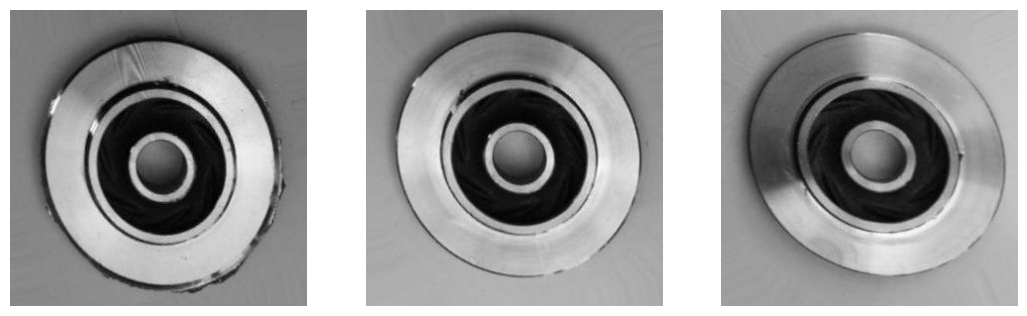

In [3]:
visualize_images(train_def)

#### Visualization of normal images

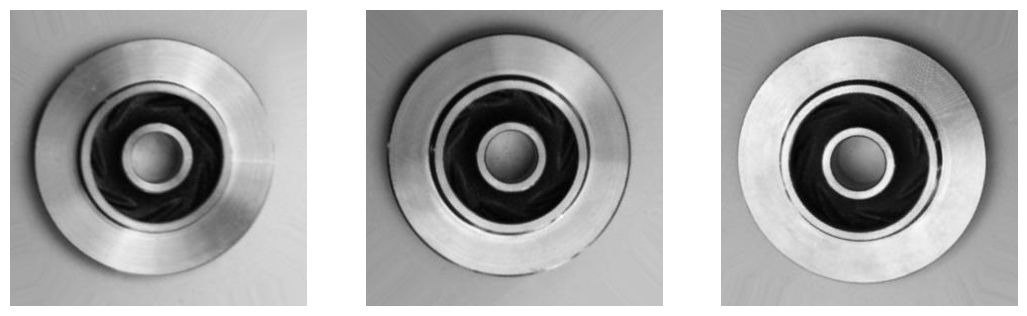

In [4]:
visualize_images(train_ok)

####  Read Kaggle data and load to Pandas Dataframe

In [5]:
# Create empty dataframes
train = pd.DataFrame(columns=['filepath', 'label'])
test = pd.DataFrame(columns=['filepath', 'label'])

# List the files in each folder
def_files = os.listdir(train_def)
ok_files = os.listdir(train_ok)
def_files_test = os.listdir(test_def)
ok_files_test = os.listdir(test_ok)

# Select 20% of the data for fixing the pipeline
# def_files = random.sample(def_files, round(len(def_files)*0.2))
# ok_files = random.sample(ok_files, round(len(ok_files)*0.2))
# def_files_test = random.sample(def_files_test, round(len(def_files_test)*0.2))
# ok_files_test = random.sample(ok_files_test, round(len(ok_files_test)*0.2))

# Create dataframe for each folder
def_train = pd.DataFrame({'filepath': [os.path.join(train_def, file) for file in def_files], 'label': ['defective']*len(def_files)})
ok_train = pd.DataFrame({'filepath': [os.path.join(train_ok, file) for file in ok_files], 'label': ['normal']*len(ok_files)})
def_test = pd.DataFrame({'filepath': [os.path.join(test_def, file) for file in def_files_test], 'label': ['defective']*len(def_files_test)})
ok_test = pd.DataFrame({'filepath': [os.path.join(test_ok, file) for file in ok_files_test], 'label': ['normal']*len(ok_files_test)})

# Concatenate both dataframe
train = pd.concat([train,def_train,ok_train], ignore_index=True)
test = pd.concat([test,def_test,ok_test], ignore_index=True)

# Adding the image column to the dataframes
train['image'] = train['filepath'].apply(lambda x: plt.imread(x))
test['image'] = test['filepath'].apply(lambda x: plt.imread(x))



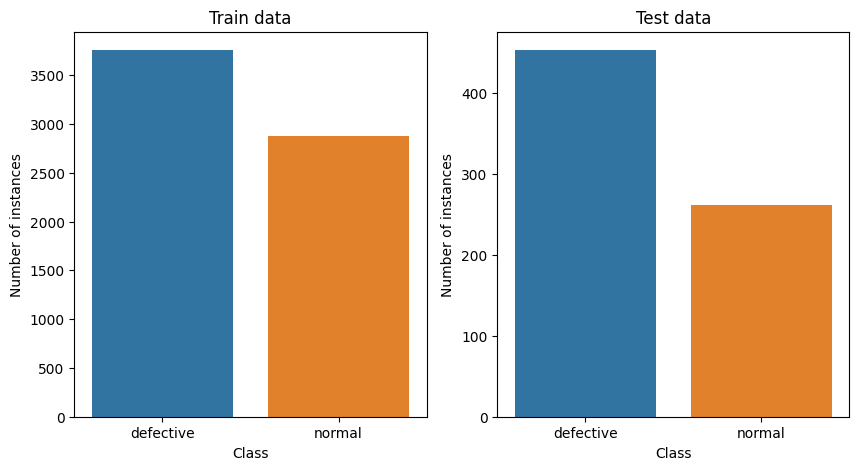

In [6]:
# Count the number of instances of each class in dataframe 1
class_counts1 = train['label'].value_counts()

# Count the number of instances of each class in dataframe 2
class_counts2 = test['label'].value_counts()

# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Create a bar plot of the class counts in dataframe 1
sns.barplot(x=class_counts1.index, y=class_counts1.values, ax=axs[0])
axs[0].set_title("Train data")
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Number of instances')

# Create a bar plot of the class counts in dataframe 2
sns.barplot(x=class_counts2.index, y=class_counts2.values, ax=axs[1])
axs[1].set_title("Test data")
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Number of instances')

plt.show()

### Prepare data to feed a Tensorflow model

We will use part of the train data for model validation and fine-tuning, while the test dataset will be used only after finalizing our model for evaluation.

In [7]:
# convert 'image' column to a 4D numpy array
X = np.stack(train['image'].values)
X_test = np.stack(test['image'].values)

# convert 'label' column to a 1D numpy array
y = np.array(train['label'].values)
y_test = np.array(test['label'].values)

# one-hot encode the labels
y = pd.get_dummies(y).values
y_test = pd.get_dummies(y_test).values

X_train = X.copy()
y_train = y.copy()

# # split the trainning data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123)

## Model creation

### Custom CNN model

In [8]:
# helper functions

def plot_metrics(history):
    
    '''plots the the metrics of the compliled model'''
    
    metrics = ['loss', 'accuracy']
    mpl.rcParams['figure.figsize'] = (10,8)
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric],  label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()
        
def plot_cm(y_true, y_pred, class_names=['def', 'normal'], ax=None, model_name=''):
    cm = confusion_matrix(y_true, y_pred)
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d",ax=ax)
    ax.set_title('{}'.format(model_name))
    ax.set_xlabel('Predicted label')
    ax.set_xticks(np.arange(2)+.5, class_names, rotation=0)
    ax.set_ylabel('Actual label')
    ax.set_yticks(np.arange(2)+.5, class_names, rotation=90)
    return ax


def get_model_size(file):
    # Returns the size of a saved model in MB.
    return round(os.stat(file).st_size/1e6, 2)


### Data Standarization and Augmentation

The values of the channels in an RGB image are typically in the range of 0 to 255, which is not ideal for training a neural network. One common strategy to prepare these images for neural networks is to scale the values down to a smaller range, usually between 0 and 1. We use the `tf.keras.layers.Rescaling` layer in TensorFlow to accomplish this standardization and adjust the channel values  of each image to be in the [0, 1] range. 

Moreover, we will augment our data to make our model more robust to unseen images. Data augmentation increases the diversity of the training set by applying random (but realistic) transformations, such as image rotation.


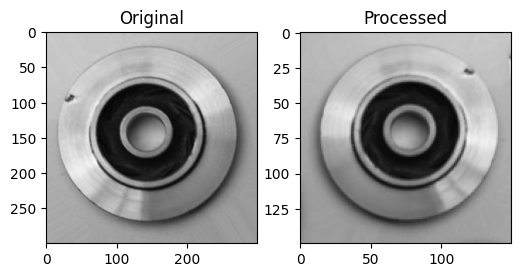

In [9]:
# select the 1st image of the training set
image = X_train[1]

IMG_SIZE = 150

rescale_and_augment = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(scale=1./255),
  
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  
])

mpl.rcParams['figure.figsize'] = (6,4)

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original')
plt.subplot(1, 2, 2)
processed_image = rescale_and_augment(image)
plt.imshow(processed_image)
plt.title('Processed')
plt.show()

In [10]:
image.shape, processed_image.numpy().shape

((300, 300, 3), (150, 150, 3))

As can be seen below, these layers are included in the model. When all data preprocessing is part of the model, other people can load and use the model without having to be aware of how each feature is expected to be encoded & normalized. The inference model will be able to process raw images or raw structured data, and will not require users of the model to be aware of the details of e.g. whether image pixel values are normalized to [-1, +1] or to [0, 1], etc. 

In [12]:
def create_model(IMG_SIZE=300, RESIZE=300):
    # create a CNN model
    model = models.Sequential()
    model.add(layers.Input(shape=(IMG_SIZE,IMG_SIZE,3)))
    # Add the preprocessing layers
    if IMG_SIZE != RESIZE:
        model.add(layers.Resizing(RESIZE, RESIZE))
    model.add(layers.Rescaling(scale=1./255))
    model.add(layers.RandomFlip("horizontal_and_vertical"))
    model.add(layers.RandomRotation(0.2))
    # Add convolutional and dense layers
    model.add(layers.Conv2D(16, (3, 3), activation='relu' ))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))
    return model
    
model = create_model()
model_s = create_model(RESIZE=150)
model_vs = create_model(RESIZE=75)

In [15]:
# This function keeps the initial learning rate for the first 5 epochs and decreases it exponentially after that.
def decay(epoch, lr):
    print(f'The learning rate for epoch {epoch+1} is {lr}')
    return lr * math.exp(-0.1)

# callback functions used during training                
stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tqdm_callback = tfa.callbacks.TQDMProgressBar()
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(decay)


# Hyper-parameters                
BATCH_SIZE = 32
EPOCHS = 15
VAL_SPLIT = 0.25

In [14]:
# compile models
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model_s.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model_vs.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# train models
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,  validation_split=VAL_SPLIT,
                   callbacks=[tqdm_callback, stop_callback], verbose=0)

history_s = model_s.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,  validation_split=VAL_SPLIT,
                   callbacks=[tqdm_callback, stop_callback], verbose=0)

history_vs = model_vs.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,  validation_split=VAL_SPLIT,
                   callbacks=[tqdm_callback, stop_callback], verbose=0)



Training:   0%|                                         0/15 ETA: ?s,  ?epochs/s

Epoch 1/15


0/156                                                                 ETA: ?s - 

Epoch 2/15


0/156                                                                 ETA: ?s - 

Epoch 3/15


0/156                                                                 ETA: ?s - 

Epoch 4/15


0/156                                                                 ETA: ?s - 

Epoch 5/15


0/156                                                                 ETA: ?s - 

Epoch 6/15


0/156                                                                 ETA: ?s - 

Epoch 7/15


0/156                                                                 ETA: ?s - 

Epoch 8/15


0/156                                                                 ETA: ?s - 

Epoch 9/15


0/156                                                                 ETA: ?s - 

Epoch 10/15


0/156                                                                 ETA: ?s - 

Epoch 11/15


0/156                                                                 ETA: ?s - 

Epoch 12/15


0/156                                                                 ETA: ?s - 

Epoch 13/15


0/156                                                                 ETA: ?s - 

Epoch 14/15


0/156                                                                 ETA: ?s - 

Epoch 15/15


0/156                                                                 ETA: ?s - 

Training:   0%|                                         0/15 ETA: ?s,  ?epochs/s

Epoch 1/15


0/156                                                                 ETA: ?s - 

Epoch 2/15


0/156                                                                 ETA: ?s - 

Epoch 3/15


0/156                                                                 ETA: ?s - 

Epoch 4/15


0/156                                                                 ETA: ?s - 

Epoch 5/15


0/156                                                                 ETA: ?s - 

Epoch 6/15


0/156                                                                 ETA: ?s - 

Epoch 7/15


0/156                                                                 ETA: ?s - 

Epoch 8/15


0/156                                                                 ETA: ?s - 

Epoch 9/15


0/156                                                                 ETA: ?s - 

Epoch 10/15


0/156                                                                 ETA: ?s - 

Epoch 11/15


0/156                                                                 ETA: ?s - 

Epoch 12/15


0/156                                                                 ETA: ?s - 

Epoch 13/15


0/156                                                                 ETA: ?s - 

Epoch 14/15


0/156                                                                 ETA: ?s - 

Epoch 15/15


0/156                                                                 ETA: ?s - 

Training:   0%|                                         0/15 ETA: ?s,  ?epochs/s

Epoch 1/15


0/156                                                                 ETA: ?s - 

Epoch 2/15


0/156                                                                 ETA: ?s - 

Epoch 3/15


0/156                                                                 ETA: ?s - 

Epoch 4/15


0/156                                                                 ETA: ?s - 

Epoch 5/15


0/156                                                                 ETA: ?s - 

Epoch 6/15


0/156                                                                 ETA: ?s - 

Epoch 7/15


0/156                                                                 ETA: ?s - 

Epoch 8/15


0/156                                                                 ETA: ?s - 

Epoch 9/15


0/156                                                                 ETA: ?s - 

Epoch 10/15


0/156                                                                 ETA: ?s - 

Epoch 11/15


0/156                                                                 ETA: ?s - 

Epoch 12/15


0/156                                                                 ETA: ?s - 

Epoch 13/15


0/156                                                                 ETA: ?s - 

Epoch 14/15


0/156                                                                 ETA: ?s - 

Epoch 15/15


0/156                                                                 ETA: ?s - 

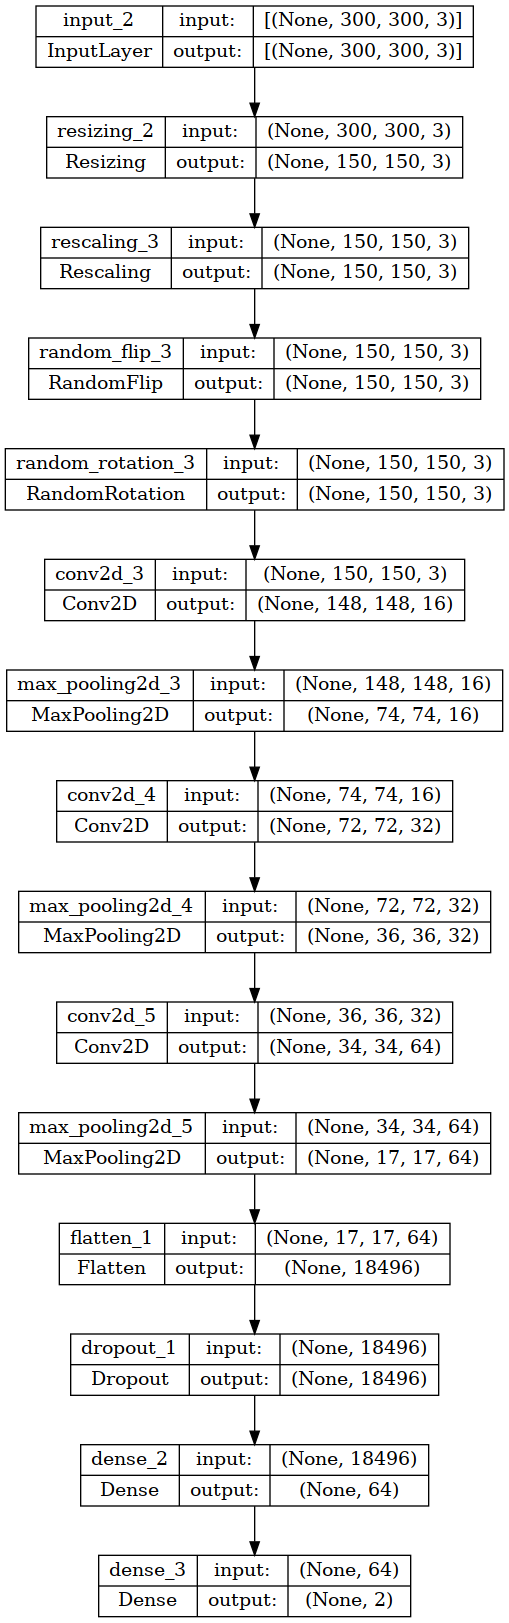

In [15]:
keras.utils.plot_model(model_s,  show_shapes=True)

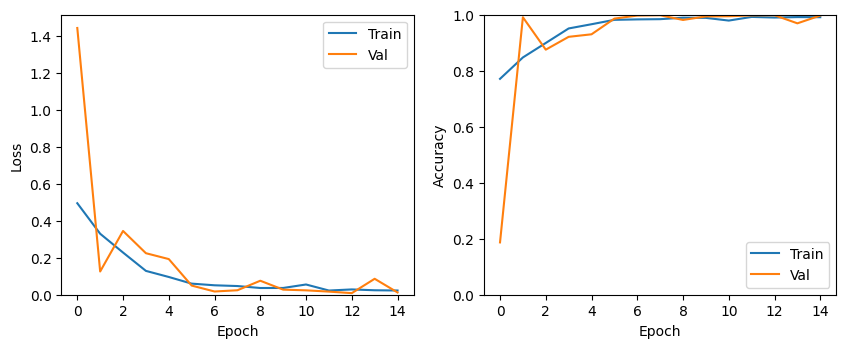

In [16]:
plot_metrics(history)

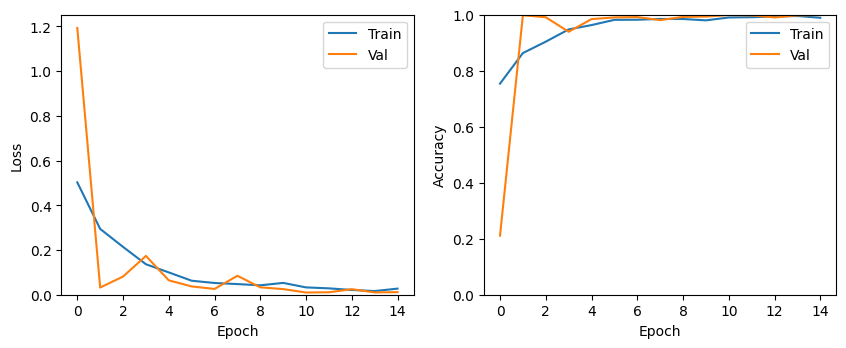

In [17]:
plot_metrics(history_s)

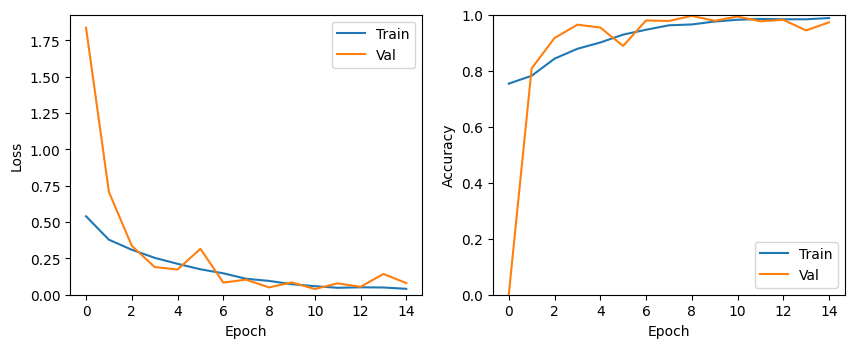

In [18]:
plot_metrics(history_vs)

#### Save models to file

In [52]:
model.save('saved_models/cnn_model.h5')
model_s.save('saved_models/cnn_model_s.h5')
model_vs.save('saved_models/cnn_model_vs.h5')

#### Load saved models

In [19]:
model = tf.keras.models.load_model('saved_models/cnn_model.h5')
model_s = tf.keras.models.load_model('saved_models/cnn_model_s.h5')
model_vs = tf.keras.models.load_model('saved_models/cnn_model_vs.h5')

### Evaluation on unseen test data

In [11]:
def evaluate_model(path_to_model, X, y):
    path_to_model = 'saved_models/'+path_to_model
    model = tf.keras.models.load_model(path_to_model)
    # Make predictions and measure inference time 
    start_time = time.time()
    predictions = model.predict(X, verbose=0)
    end_time = time.time()
    inference_time = (end_time - start_time)/(round(y.shape[0]/BATCH_SIZE))
    
    y_pred = np.argmax(predictions, axis=-1)
    y_test = np.argmax(y, axis=-1)
    
#     print(classification_report(y_test, y_pred, target_names=['def','ok'], digits= 4) )

    return {'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred),
            'Inference Time(ms)': round(inference_time*1000,2),
            'Size(MB)': get_model_size(path_to_model)}

In [21]:
models = [model, model_s, model_vs]
models_path = ['cnn_model.h5', 'cnn_model_s.h5', 'cnn_model_vs.h5']
models_names = ['CNN 300px', 'CNN 150px', 'CNN 75px']
df = pd.DataFrame(columns = [ 'Accuracy', 'Precision', 'Recall', 
                             'F1-Score', 'Inference Time(ms)', 'Size(MB)'], index=models_names)

for i, m in enumerate(models_path):
    df.iloc[i] = evaluate_model(m, X_test, y_test)

In [22]:
df

,Accuracy,Precision,Recall,F1-Score,Inference Time(ms),Size(MB)
CNN 300px,1.0,1.0,1.0,1.0,15.0,60.55
CNN 150px,0.998601,0.996198,1.0,0.998095,12.37,14.55
CNN 75px,0.974825,0.948529,0.984733,0.966292,11.91,2.75


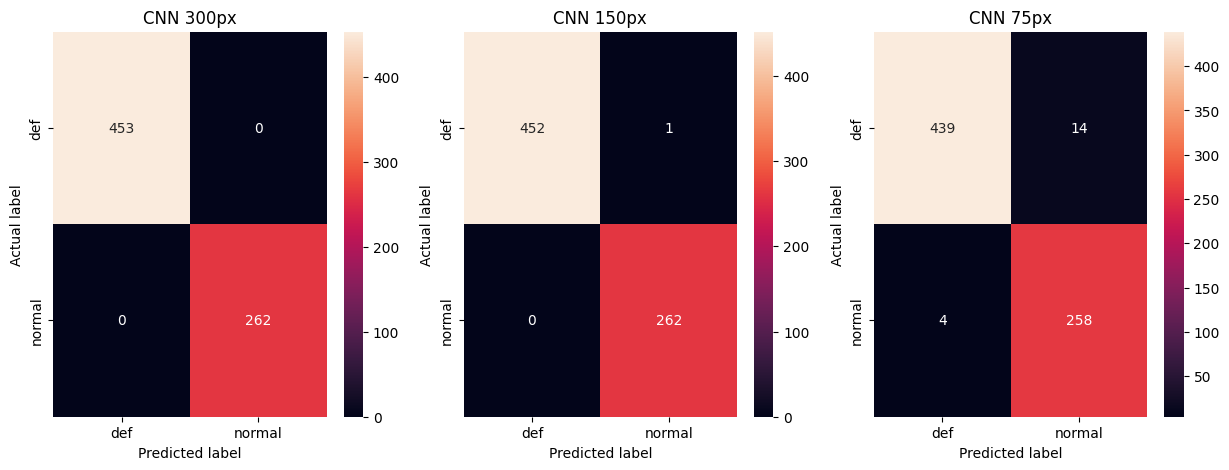

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, m in enumerate(models):
    
    predictions = m.predict(X_test, verbose=0)
    y_pred = np.argmax(predictions, axis=-1)
    y_actual = np.argmax(y_test, axis=-1)
    plot_cm(y_actual, y_pred, ax=axs[i], model_name=models_names[i])

plt.show()

### Find and intreprete missclassified images

LIME (Local Interpretable Model-agnostic Explanations) is a method for explaining the predictions of any classifier or regressor in a human-understandable way. It works by approximating the complex model's behavior locally around the instance to be explained by training an interpretable model on a neighborhood of the instance.

The basic idea behind LIME is to fit an interpretable model to the predictions of the complex model in the vicinity of the instance to be explained. LIME creates an explanation by fitting an interpretable model on a small subset of instances that are similar to the instance to be explained.

The interpretable model is trained on the neighborhood of the instance, which is defined by generating perturbed versions of the instance. The perturbations are based on the feature space of the input data. The interpretable model is trained to predict the same output as the complex model on this neighborhood, and the interpretable model's parameters are used to explain the predictions of the complex model.

Finally, LIME generates an explanation by highlighting the features that have the highest importance according to the interpretable model. These features are the ones that most strongly influence the predictions of the complex model, and are therefore considered most important for understanding the complex model's behavior.

In [24]:
from lime.wrappers.scikit_image import SegmentationAlgorithm
import skimage


def plot_spx(image, explainer,kernel_size=10, weight=0.9):
    # Get the superpixel segmentation
    segmentation = quickshift(image, kernel_size=kernel_size, max_dist=200, ratio=0.2)

    # Create an empty image for the plot
    output_image = np.zeros_like(segmentation, dtype=np.uint8)

    # Get the superpixel weights and find the threshold
    try:
        superpixel_weights = explainer.local_exp[1]
    except:
        superpixel_weights = explainer.local_exp[0]
    threshold = np.percentile(superpixel_weights, weight)

    # Color the superpixels that have a weight above the threshold
    for superpixel_id, weight in superpixel_weights:
        if weight > threshold:
            output_image[segmentation == superpixel_id] = 255

    # Display the output image
    return plt.imshow(output_image)

def plot_sp(explainer, weight=0.9):
    # Get the superpixel weights and find the threshold
    try:
        superpixel_weights = explainer.local_exp[1]
    except:
        superpixel_weights = explainer.local_exp[0]
    threshold = np.percentile(superpixel_weights, weight)
    temp, mask = explainer.get_image_and_mask(
        explainer.top_labels[0], 
        positive_only=True, 
        num_features=8, 
        hide_rest=False)
    return plt.imshow(skimage.segmentation.mark_boundaries(temp/255, mask))

In [87]:
# Select model for explaination
models_path = ['cnn_model.h5', 'cnn_model_s.h5', 'cnn_model_vs.h5']
# Here we select the CNN 75X75 model, 3rd in the above list
m = tf.keras.models.load_model('saved_models/'+ models_path[2])
predictions = m.predict(X_test, verbose=0)
y_pred = np.argmax(predictions, axis=-1)
y_actual = np.argmax(y_test, axis=-1)

#### The following cell outputs some misclassified images for the selected model. 

The heatmap illustrates the contribution of each input image segment to each class. The segments with green color contribute to the predicted class while the red ones to the opposite class. For example, if the model predicts that the given image is deficient. The green parts of the figure were predicted as deficient, and the red ones as normal. The third figure shows the area of the figure that mostly contributed to the predicted class.

  0%|          | 0/1000 [00:00<?, ?it/s]

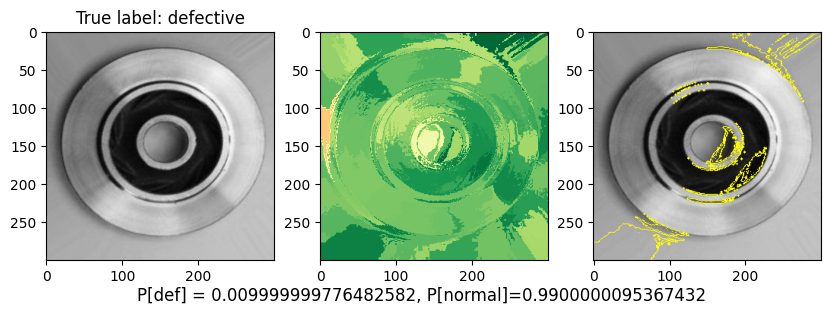

  0%|          | 0/1000 [00:00<?, ?it/s]

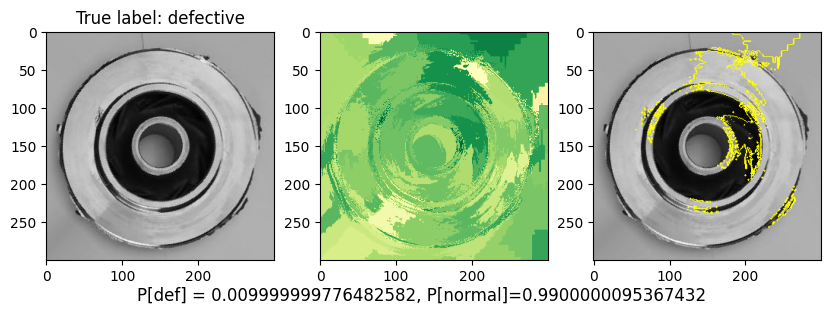

  0%|          | 0/1000 [00:00<?, ?it/s]

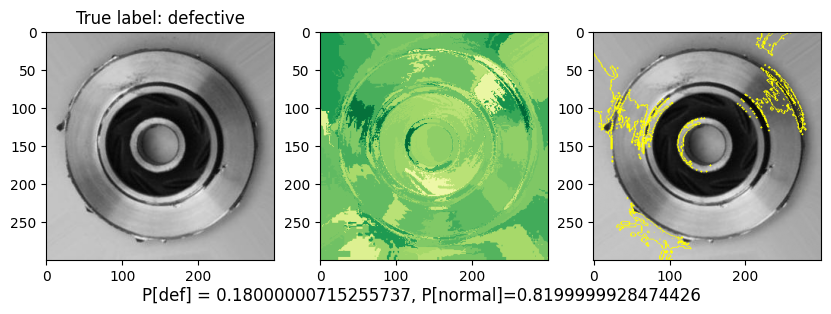

  0%|          | 0/1000 [00:00<?, ?it/s]

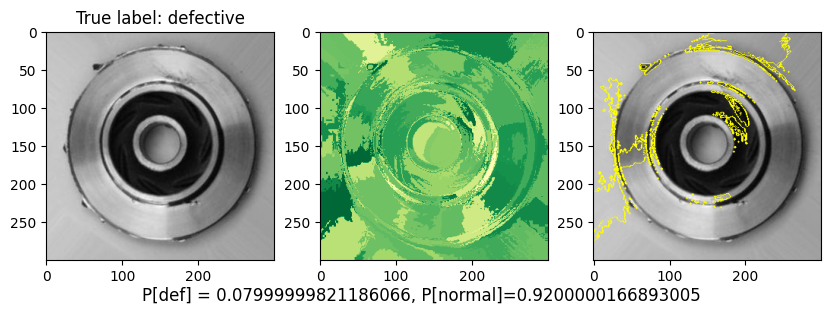

  0%|          | 0/1000 [00:00<?, ?it/s]

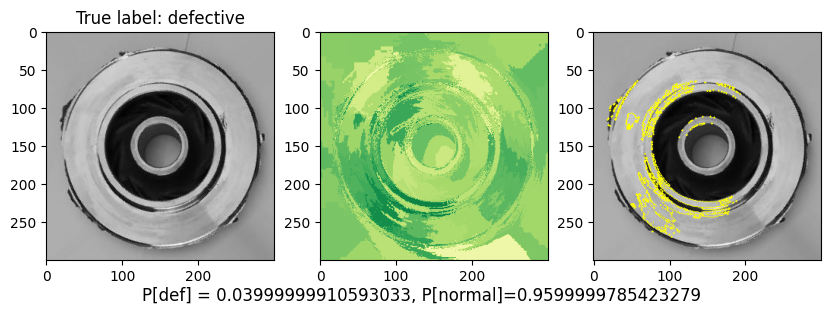

  0%|          | 0/1000 [00:00<?, ?it/s]

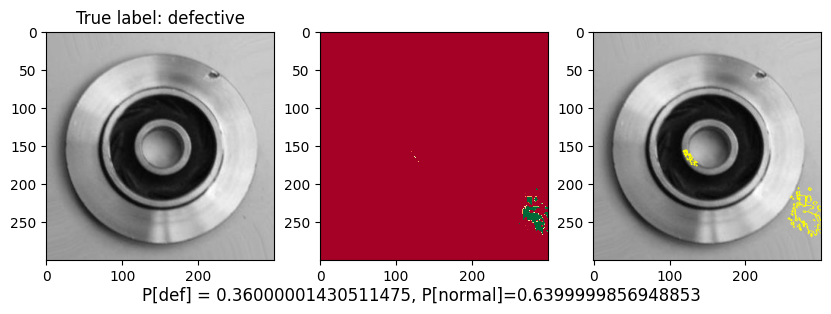

  0%|          | 0/1000 [00:00<?, ?it/s]

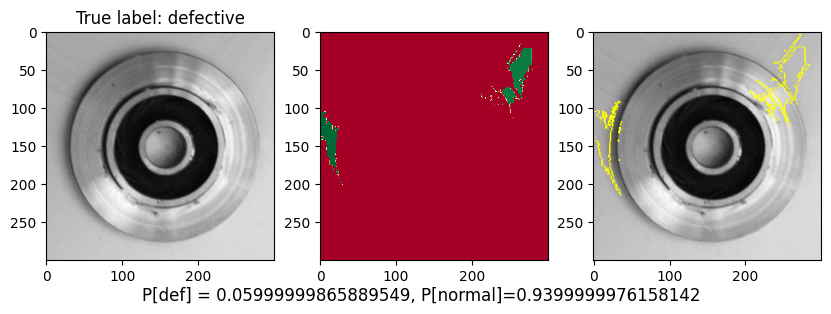

  0%|          | 0/1000 [00:00<?, ?it/s]

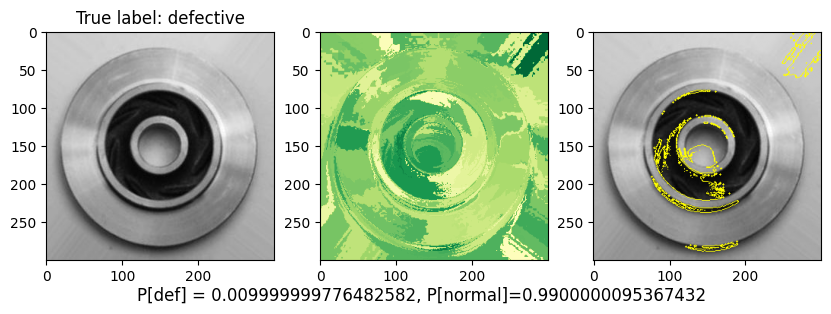

  0%|          | 0/1000 [00:00<?, ?it/s]

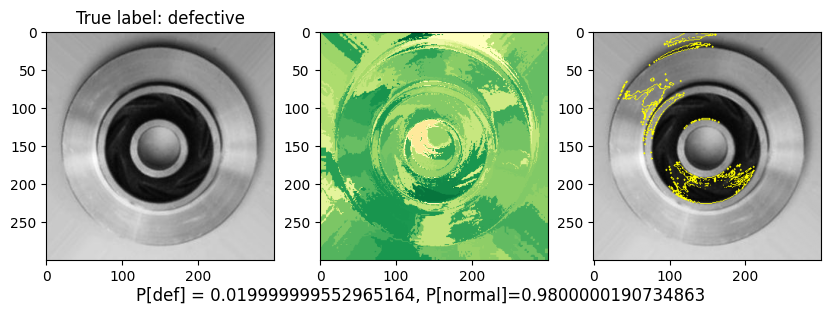

  0%|          | 0/1000 [00:00<?, ?it/s]

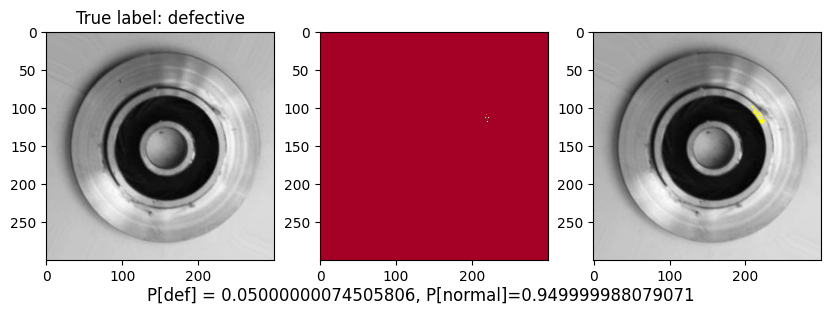

In [88]:
mpl.rcParams['figure.figsize'] = (10, 8)
misclassified_examples = (y_actual!=y_pred)
n_figs = 3
c= 0
for i, misclassification in enumerate(misclassified_examples):
    if misclassification and c<10:
        c+=1
        # plot input image
        plt.subplot(1, n_figs, 1)
        explainer = lime_image.LimeImageExplainer()
        image = X_test[i].reshape(1,300,300,3)
        pred = m.predict(image,verbose=0)[0]
        image = X_test[i]
        explanation = explainer.explain_instance(
                    image.astype('double'), 
                    m, 
                    top_labels=1, 
                    hide_color=0, 
                    num_samples=1000, 
                    random_seed=123)  

        plt.imshow(image)
        plt.title(f"True label: {test['label'][i]}")
        p0 = round(pred[0],2)
        p1 = round(pred[1],2)
        plt.suptitle(f'P[def] = {p0}, P[normal]={p1}',y=0.32)
        plt.subplot(1, n_figs, 2) # index 2
        # Select the same class explained on the figures above.
        ind =  explanation.top_labels[0]
        # Map each explanation weight to the corresponding superpixel
        dict_heatmap = dict(explanation.local_exp[ind])
        heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
        # The visualization makes more sense if a symmetrical colorbar is used.
        plt.imshow(heatmap, cmap='RdYlGn', vmin  = -heatmap.max(), vmax = heatmap.max())
        plt.subplot(1, n_figs, 3)
        plot_sp(explanation)
        
        plt.show()
      

## TF Lite transformation



In [89]:
# Load TensorFlow model
model = tf.keras.models.load_model('saved_models/cnn_model.h5')
model_s = tf.keras.models.load_model('saved_models/cnn_model_s.h5')
model_vs = tf.keras.models.load_model('saved_models/cnn_model_vs.h5')

#### Convert the original TF models to TFLite format

In [25]:
# Convert models to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
        tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
    ]
tflite_model = converter.convert()

converter = tf.lite.TFLiteConverter.from_keras_model(model_s)
converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
        tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
    ]
tflite_model_s = converter.convert()

converter = tf.lite.TFLiteConverter.from_keras_model(model_vs)
converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
        tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
    ]
tflite_model_vs = converter.convert()

# Save TFLite model
with open('saved_models/cnn_model.tflite', 'wb') as f:
    f.write(tflite_model)
    
with open('saved_models/cnn_model_s.tflite', 'wb') as f:
    f.write(tflite_model_s)
    
with open('saved_models/cnn_model_vs.tflite', 'wb') as f:
    f.write(tflite_model_vs)

### Quantization

Quantization is the process of reducing the precision of the weights and activations of a neural network, typically from 32-bit floating point to 8-bit integer or 16-bit floating point.

There are two forms of quantization: post-training quantization and quantization aware training. Post-training quantization it's easier to use, though quantization aware training is often better for model accuracy.

Source: [https://www.tensorflow.org/model_optimization/guide/quantization/training]

#### Post-training quantization

Post-training quantization is a static quantization technique where the quantization is applied to the already trained model. This method can be applied to both weights and activations, or just the weights. The quantization process can be done with minimal or zero loss of accuracy, and it reduces the model size and computational requirements. This technique is mostly used on mobile devices or other resource-constrained platforms.

In [26]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

with open('saved_models/cnn_model_quant.tflite', 'wb') as f:
    f.write(tflite_quant_model)
    
converter = tf.lite.TFLiteConverter.from_keras_model(model_s)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model_s = converter.convert()

with open('saved_models/cnn_model_s_quant.tflite', 'wb') as f:
    f.write(tflite_quant_model_s)
    
converter = tf.lite.TFLiteConverter.from_keras_model(model_vs)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model_vs = converter.convert()

with open('saved_models/cnn_model_vs_quant.tflite', 'wb') as f:
    f.write(tflite_quant_model_vs)

#### Quantization aware training

Quantization aware training (QAT) involves training a model with knowledge of the quantization process that will be used to reduce the precision of the model's weights and activations during deployment. This allows the model to be more accurately represented at lower precision, resulting in reduced memory and computational requirements. QAT also helps to mitigate the loss of accuracy that can occur when a model is quantized.

In [27]:
def apply_quantization(layer):
    if isinstance(layer, layers.Conv2D):
        return tfmot.quantization.keras.quantize_annotate_layer(layer)
    if isinstance(layer, layers.Dense):
        return tfmot.quantization.keras.quantize_annotate_layer(layer)
    return layer

In [28]:
# QAT for each model
quant_aware_model = tf.keras.models.clone_model(model, clone_function=apply_quantization)
quant_aware_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
history_quant_aware_model = quant_aware_model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VAL_SPLIT,
                  callbacks=[tqdm_callback, stop_callback], verbose=0 )

quant_aware_model_s = tf.keras.models.clone_model(model_s, clone_function=apply_quantization)
quant_aware_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
history_quant_aware_model_s = quant_aware_model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VAL_SPLIT,
                  callbacks=[tqdm_callback, stop_callback], verbose=0 )

quant_aware_model_vs = tf.keras.models.clone_model(model_vs, clone_function=apply_quantization)
quant_aware_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
history_quant_aware_model_vs = quant_aware_model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VAL_SPLIT,
                  callbacks=[tqdm_callback, stop_callback], verbose=0 )


Training:   0%|                                         0/15 ETA: ?s,  ?epochs/s

Epoch 1/15


0/156                                                                 ETA: ?s - 

Epoch 2/15


0/156                                                                 ETA: ?s - 

Epoch 3/15


0/156                                                                 ETA: ?s - 

Epoch 4/15


0/156                                                                 ETA: ?s - 

Epoch 5/15


0/156                                                                 ETA: ?s - 

Epoch 6/15


0/156                                                                 ETA: ?s - 

Epoch 7/15


0/156                                                                 ETA: ?s - 

Epoch 8/15


0/156                                                                 ETA: ?s - 

Epoch 9/15


0/156                                                                 ETA: ?s - 

Epoch 10/15


0/156                                                                 ETA: ?s - 

Epoch 11/15


0/156                                                                 ETA: ?s - 

Epoch 12/15


0/156                                                                 ETA: ?s - 

Epoch 13/15


0/156                                                                 ETA: ?s - 

Epoch 14/15


0/156                                                                 ETA: ?s - 

Epoch 15/15


0/156                                                                 ETA: ?s - 

Training:   0%|                                         0/15 ETA: ?s,  ?epochs/s

Epoch 1/15


0/156                                                                 ETA: ?s - 

Epoch 2/15


0/156                                                                 ETA: ?s - 

Epoch 3/15


0/156                                                                 ETA: ?s - 

Epoch 4/15


0/156                                                                 ETA: ?s - 

Epoch 5/15


0/156                                                                 ETA: ?s - 

Epoch 6/15


0/156                                                                 ETA: ?s - 

Epoch 7/15


0/156                                                                 ETA: ?s - 

Epoch 8/15


0/156                                                                 ETA: ?s - 

Epoch 9/15


0/156                                                                 ETA: ?s - 

Epoch 10/15


0/156                                                                 ETA: ?s - 

Epoch 11/15


0/156                                                                 ETA: ?s - 

Training:   0%|                                         0/15 ETA: ?s,  ?epochs/s

Epoch 1/15


0/156                                                                 ETA: ?s - 

Epoch 2/15


0/156                                                                 ETA: ?s - 

Epoch 3/15


0/156                                                                 ETA: ?s - 

Epoch 4/15


0/156                                                                 ETA: ?s - 

Epoch 5/15


0/156                                                                 ETA: ?s - 

Epoch 6/15


0/156                                                                 ETA: ?s - 

Epoch 7/15


0/156                                                                 ETA: ?s - 

Epoch 8/15


0/156                                                                 ETA: ?s - 

Epoch 9/15


0/156                                                                 ETA: ?s - 

Epoch 10/15


0/156                                                                 ETA: ?s - 

Epoch 11/15


0/156                                                                 ETA: ?s - 

Epoch 12/15


0/156                                                                 ETA: ?s - 

Epoch 13/15


0/156                                                                 ETA: ?s - 

Epoch 14/15


0/156                                                                 ETA: ?s - 

Epoch 15/15


0/156                                                                 ETA: ?s - 

- Save QAT models to TFLite format

In [29]:
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_aware_model = converter.convert()

with open('saved_models/cnn_model_quant_aware.tflite', 'wb') as f:
    f.write(tflite_quant_aware_model)
    
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model_s)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_aware_model_s = converter.convert()

with open('saved_models/cnn_model_s_quant_aware.tflite', 'wb') as f:
    f.write(tflite_quant_aware_model_s)
    
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model_vs)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_aware_model_vs = converter.convert()

with open('saved_models/cnn_model_vs_quant_aware.tflite', 'wb') as f:
    f.write(tflite_quant_aware_model_vs)

### Compare model performance 

In [30]:
def eval_lite_model(path_to_model, X, y):
    path_to_model = 'saved_models/'+path_to_model
    interpreter = tf.lite.Interpreter(model_path=path_to_model)
    interpreter.allocate_tensors()
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Run predictions on every image in the "test" dataset.
    y_pred = []
    start_time = time.time()
    for i, test_image in enumerate(tqdm.tqdm(X)):
        # Pre-processing: add batch dimension and convert to float32 to match with the model's input data format.
        test_image = np.expand_dims(test_image, axis=0)
        try: 
            interpreter.set_tensor(input_index, test_image)
        except ValueError:
            test_image = test_image.astype(np.float32)
            interpreter.set_tensor(input_index, test_image)
            pass

        # Run inference
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest probability
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        y_pred.append(digit)
    end_time = time.time()

    # Compare prediction results with ground truth labels to calculate accuracy.
    y_pred = np.array(y_pred)
    y_test = np.argmax(y, axis=-1)
    inference_time = (end_time - start_time)/y.shape[0]
    return {'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred),
            'Inference Time(ms)': round(inference_time*1000,2),
            'Size(MB)': get_model_size(path_to_model)}


In [31]:
models = ['cnn_model.tflite', 'cnn_model_s.tflite', 'cnn_model_vs.tflite', 
         'cnn_model_quant.tflite', 'cnn_model_s_quant.tflite', 'cnn_model_vs_quant.tflite',
         'cnn_model_quant_aware.tflite', 'cnn_model_s_quant_aware.tflite', 'cnn_model_vs_quant_aware.tflite']
models_names = ['CNN 300px lite', 'CNN 150px lite', 'CNN 75px lite',
                'CNN 300px lite PTQ', 'CNN 150px lite PTQ', 'CNN 75px lite PTQ',
                'CNN 300px lite QAT', 'CNN 150px lite QAT', 'CNN 75px lite QAT',]

df2 = pd.DataFrame(columns = [ 'Accuracy', 'Precision', 'Recall', 
                             'F1-Score', 'Inference Time(ms)','Size(MB)'], index=models_names)

for i, m in enumerate(models):
    df2.iloc[i] = eval_lite_model(m, X_test, y_test)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
100%|███████████████████████████████████████| 715/715 [00:00<00:00, 1848.84it/s]


In [32]:
df2

,Accuracy,Precision,Recall,F1-Score,Inference Time(ms),Size(MB)
CNN 300px lite,1.0,1.0,1.0,1.0,10.37,20.17
CNN 150px lite,0.998601,0.996198,1.0,0.998095,2.48,4.83
CNN 75px lite,0.974825,0.948529,0.984733,0.966292,0.62,0.9
CNN 300px lite PTQ,0.994406,0.984962,1.0,0.992424,8.14,5.05
CNN 150px lite PTQ,0.998601,0.996198,1.0,0.998095,2.01,1.22
CNN 75px lite PTQ,0.976224,0.95203,0.984733,0.968105,0.53,0.23
CNN 300px lite QAT,1.0,1.0,1.0,1.0,8.1,5.05
CNN 150px lite QAT,0.998601,0.996198,1.0,0.998095,2.03,1.22
CNN 75px lite QAT,0.976224,0.95203,0.984733,0.968105,0.54,0.23


In [33]:
resutls = pd.concat([df, df2]).sort_index()

In [34]:
resutls

,Accuracy,Precision,Recall,F1-Score,Inference Time(ms),Size(MB)
CNN 150px,0.998601,0.996198,1.0,0.998095,12.37,14.55
CNN 150px lite,0.998601,0.996198,1.0,0.998095,2.48,4.83
CNN 150px lite PTQ,0.998601,0.996198,1.0,0.998095,2.01,1.22
CNN 150px lite QAT,0.998601,0.996198,1.0,0.998095,2.03,1.22
CNN 300px,1.0,1.0,1.0,1.0,15.0,60.55
CNN 300px lite,1.0,1.0,1.0,1.0,10.37,20.17
CNN 300px lite PTQ,0.994406,0.984962,1.0,0.992424,8.14,5.05
CNN 300px lite QAT,1.0,1.0,1.0,1.0,8.1,5.05
CNN 75px,0.974825,0.948529,0.984733,0.966292,11.91,2.75
CNN 75px lite,0.974825,0.948529,0.984733,0.966292,0.62,0.9
